In this notebook we will be scrapping the movie list page of different production company from wikipedia.
Once that is done we will scrape the movie's wikipedia page and save its data like the title of the movie, directed by, 
produced by, starring, release date, etc. All the data releated to the movie will be saved in a json file. Each movie will have
one json file.
This is the initial table which will be scapped. This information will be saved in an excel file.

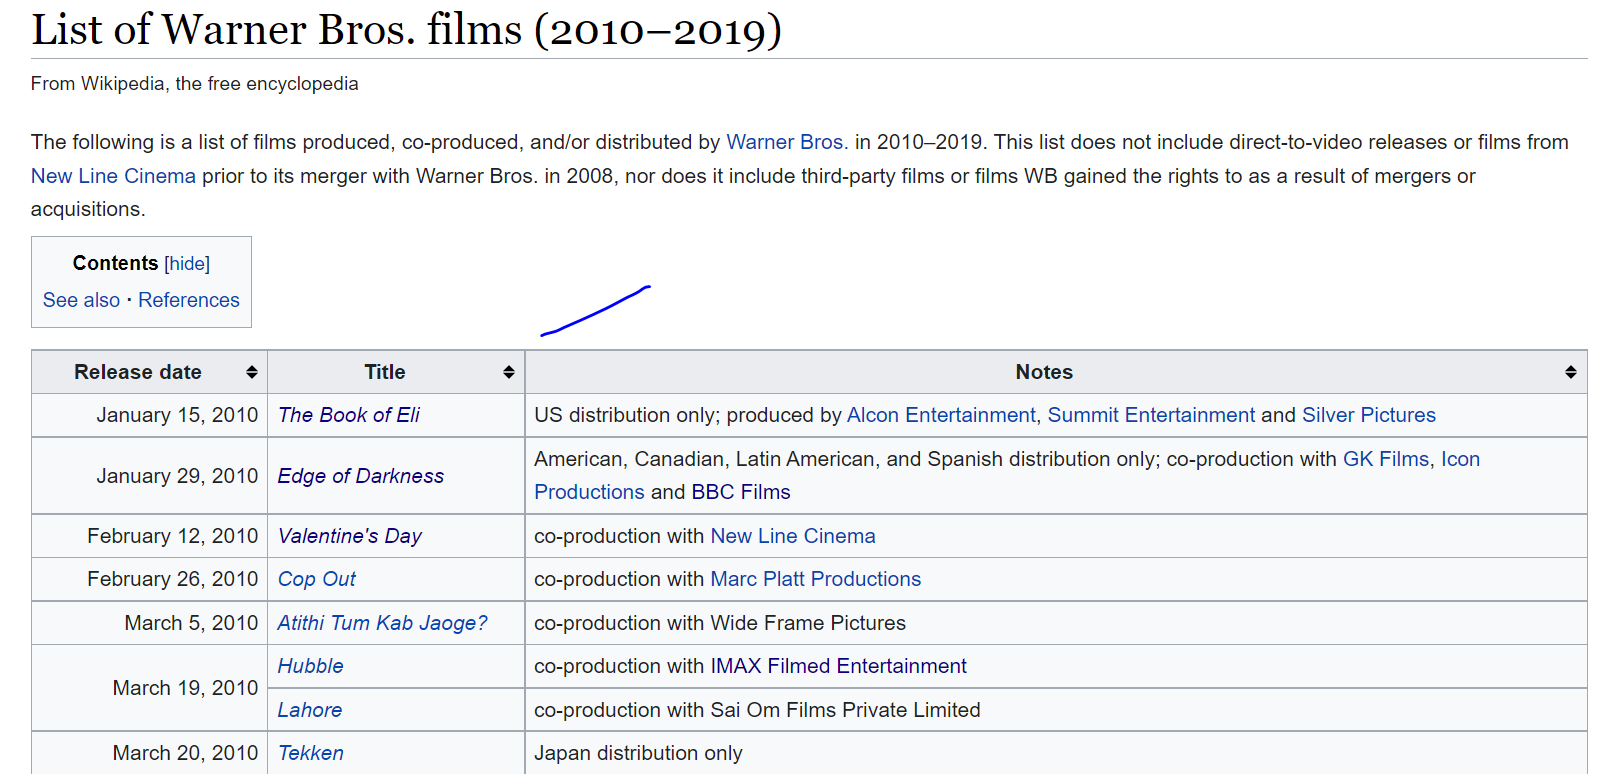

Once this data is saved we will traverse to the movie's wikipedia page and scrape its data into a json file.
This information will be saved in the json.

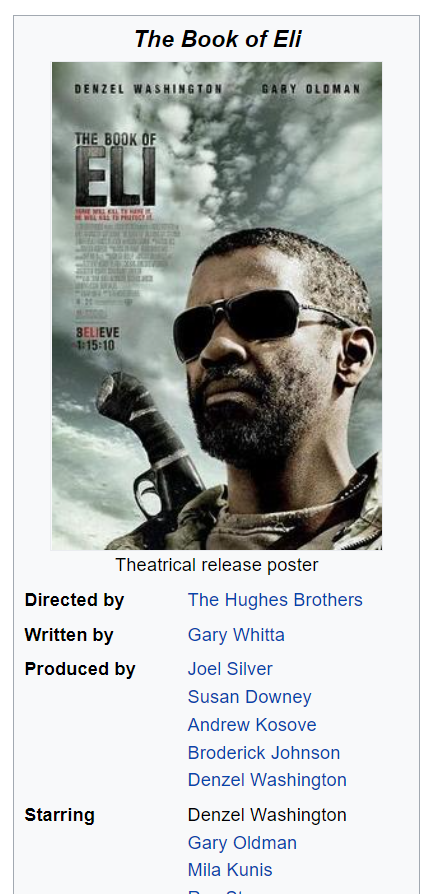

There are still some room for improvement in the code. For example the json files generated still has the citations marking
in them.

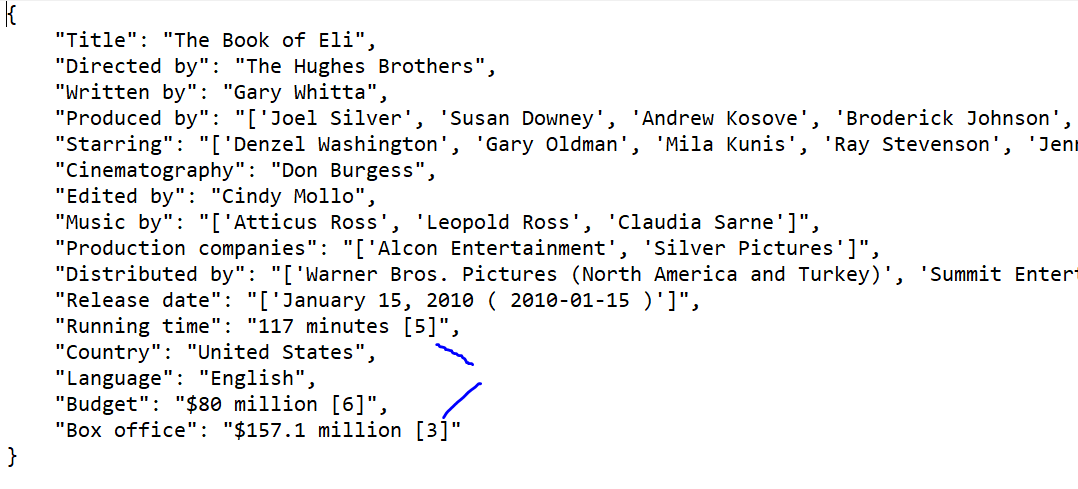

In [2]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup as bs
import json

### Constant Variables

In [3]:
mainLink='https://en.wikipedia.org/'

##Enter the wikipedia movie list site.

#movieList='wiki/List_of_Walt_Disney_Pictures_films'
#movieList='wiki/List_of_Paramount_Pictures_films_(2000–2009)'
movieList='wiki/List_of_Warner_Bros._films_(2010–2019)'
#movieList='wiki/List_of_Warner_Bros._films_(2010–2019)'

##Excel file name
excel_file='movielist_WB_{}.xlsx'

### Function to extract overall data from the site

In [4]:
def extractHTML(link):
    r= requests.get(link)
    soup1= bs(r.content)
    return soup1

### Function to extract the column name for a table
It expects table data

In [5]:
def extractColumnNames(table):
    column=tableData.find('tbody').find_all('th')
    column=[str(c.get_text()).strip() for c in column]
    return column

### Function to extract table row data and save it into appropriate files

In [6]:
def extractRows(table,columnName, fileName):
    rows= table.find('tbody').find_all('tr')    
    l=[]    
    rowData=[]
    for i in range(0,len(rows)):
        td= rows[i].find_all('td')
        l.append(td)
        row=[str(tr1.get_text()).strip() for tr1 in td]
        if len(row) == 2:
            row.insert(0,rowData[i-1][0])
        rowData.append(row)
        
    link= check_a_tag(l)
    df= pd.DataFrame(rowData,columns=columnName)
    df.to_excel(fileName, index=False)
    return link
    

### Function to extract the href from the table

In [7]:
def check_a_tag(l):
    link=[]
    for i in range(0,len(l)):
        for index,row in enumerate(l[i]):
            if index == 1:
                li=l[i][index].find('a')
                if li is None:
                    continue
                else:
                    link.append(li)
    return link        

### return the content value from the infobox

In [8]:
def get_content_value(row_data):
    if row_data.find('li'):
        ##some infobox has multiple content for a single content header
        return [li.get_text(' ', strip=True).replace('\xa0', ' ') for li in row_data.find_all('li')]
    else:
        return row_data.get_text(' ', strip=True).replace('\xa0', ' ')

### Download the infobox content into a json file

In [9]:
def downloadJsonFile(data):
    for link in data:
        data1= extractHTML(mainLink+link['href'])
        info_box=data1.find(class_='infobox')
        if info_box.find_all('tr'):  
            info_rows=info_box.find_all('tr')
            movie_info={}

            for index,row in enumerate(info_rows):
                if index== 0:
                    if row.find('th'):
                        movie_info['Title']=row.find('th').get_text(' ', strip=True)
                        #json file name will the movie title
                        jsonName=row.find('th').get_text().replace(' ','_')+'.json'
                    else:
                        continue   
                ## at index 1 the movie poster is found which we are not saving
                elif index ==1:
                    continue
                else:
                    if row.find('th'):
                        content_key=row.find('th').get_text(' ', strip=True)
                        content_value=get_content_value(row.find('td'))
                        movie_info[content_key]=str(content_value).strip()
                    else:
                        continue
            json_object = json.dumps(movie_info, indent = 4)
            with open(jsonName,'w') as f:
                f.write(json_object)
        ##remove the break statement once testing is done to ensure that the data for all the movies is downloaded into different json files.
        break

### Final execution statement for scraping the data and saving it

In [10]:
##Get main data
soup= extractHTML(mainLink+movieList)

##Get table data
##if required change the className for the table
##Getting all the tables
allTable=soup.select('table.sortable')

okay=[]
for i in range(0,len(allTable)):
    fileName=excel_file.format(i+1)
    ##if required change the className for the table
    ##Getting one table data at a time
    tableData=soup.select('table.sortable')[i]
    ##Get Column Name
    columnName=extractColumnNames(tableData)
    ##Get a list of all the wiki links for different movies released
    okay=extractRows(tableData,columnName,fileName)
    ##download the json file
    downloadJsonFile(okay)